# Data Pull

In [1]:
pip install ccxt


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ccxt
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from tqdm import tqdm
import os

## Coin Universe

In [3]:
SPOT_COLUMNS = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume',
                'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']

binance_exchange = ccxt.binanceus({
    'timeout': 15000,
    'enableRateLimit': True
    # 'options': {'defaultType': 'future'}
})
markets = binance_exchange.load_markets()
all_tickers = list(markets.keys())
usdt_tickers = [ticker for ticker in all_tickers if ticker.endswith('USDT')]
active_usdt_tickers = [
    ticker for ticker in usdt_tickers if markets[ticker]['active']
]
len(active_usdt_tickers)

162

In [4]:
def get_spot(exchange, symbol, interval = '1d',
                    startTime = None,
                    endTime = None,
                    limit = 1000):

    if (startTime == None and endTime == None):
        return exchange.publicGetKlines({'symbol': symbol,
                                        'interval': interval,
                                        'limit': limit})
    elif (startTime == None and endTime != None):
        return exchange.publicGetKlines({'symbol': symbol,
                                        'interval': interval,
                                        'endTime': endTime,
                                        'limit': limit})
    elif (startTime != None and endTime == None):
        return exchange.publicGetKlines({'symbol': symbol,
                                        'interval': interval,
                                        'startTime': startTime,
                                        'limit': limit})
    else:
        return exchange.publicGetKlines({'symbol': symbol,
                                        'interval': interval,
                                        'startTime': startTime,
                                        'endTime': endTime,
                                        'limit': limit})

def convert_to_seconds(time_input):
    number = int(time_input[:-1])
    unit = time_input[-1]

    if unit == 's':
        return number
    elif unit == 'm':
        return number * 60
    elif unit == 'h':
        return number * 3600
    elif unit == 'd':
        return number * 86400
    else:
        raise ValueError("Unsupported time unit")

def transform_timestamp(timestamp_integer):
    '''
    As data points involved milliseconds, we need to transform them by constant 1000.
    '''

    return pd.to_datetime(int(timestamp_integer / 1000), utc=True, unit='s')

def transform_to_timestamp_integer(datetime_object):
    '''
    As data points involved milliseconds, we need to transform them by constant 1000.
    '''

    return int(datetime_object.timestamp() * 1000)

def obtain_full_spotdata(start_timestamp, end_timestamp, exchange, symbol, interval='1d', limit=1000):
    full_data_list = []
    curr_timestamp = start_timestamp

    while curr_timestamp < end_timestamp:
        data_list = get_spot(exchange=exchange, symbol=symbol, interval=interval, startTime=curr_timestamp, limit=limit)
        if not data_list:
            break

        full_data_list.extend(data_list)

        # Use the last candle's open time plus one interval as the new start timestamp
        last_candle = data_list[-1]
        last_timestamp = int(last_candle[0])
        # Increment by one day (in milliseconds) to avoid overlap
        curr_timestamp = last_timestamp + convert_to_seconds(interval) * 1000

        # Sleep to respect rate limits
        time.sleep(0.2)

    return full_data_list

In [5]:
start_date = "2016-01-01"
end_date = "2025-02-24"
interval = "1d"

In [6]:
def fetch_data(ticker_symbol, start_date, end_date, interval):
    # Convert dates to timestamps in milliseconds
    start_timestamp = int(((pd.to_datetime(start_date)).tz_localize('UTC')).timestamp() * 1000)
    end_timestamp = int(((pd.to_datetime(end_date)).tz_localize('UTC')).timestamp() * 1000)

    # Obtain raw data from Binance US
    full_data_list = obtain_full_spotdata(start_timestamp, end_timestamp, binance_exchange, ticker_symbol, interval=interval)

    # Create a DataFrame with the correct column names
    data = pd.DataFrame(full_data_list, columns=SPOT_COLUMNS)
    data['Open time'] = data['Open time'].apply(lambda x: transform_timestamp(int(x)))

    # Remove any duplicate entries based on 'Open time'
    data.drop_duplicates('Open time', keep='first', inplace=True)

    # Add a column to identify the ticker
    data['Ticker'] = ticker_symbol
    return data

In [7]:
all_data = []
for ticker in tqdm(active_usdt_tickers, desc="Fetching crypto data"):
    try:
        cleaned_ticker = ticker.replace('/', '')
        df = fetch_data(cleaned_ticker, start_date, end_date, interval)
        all_data.append(df)
        print(f"Data for {cleaned_ticker} fetched successfully.")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Concatenate all the DataFrames into one master DataFrame
master_data = pd.concat(all_data, ignore_index=True)

# Save the master DataFrame to a Parquet file
master_data.to_parquet("../data/raw/master_crypto_data.parquet", index=False)
print("Master parquet file saved as '../data/raw/master_crypto_data.parquet'")

Fetching crypto data:   1%|          | 1/162 [00:00<01:45,  1.53it/s]

Data for BTCUSDT fetched successfully.


Fetching crypto data:   1%|          | 2/162 [00:01<01:40,  1.59it/s]

Data for ETHUSDT fetched successfully.


Fetching crypto data:   2%|▏         | 3/162 [00:01<01:39,  1.59it/s]

Data for XRPUSDT fetched successfully.


Fetching crypto data:   2%|▏         | 4/162 [00:02<01:37,  1.62it/s]

Data for BCHUSDT fetched successfully.


Fetching crypto data:   3%|▎         | 5/162 [00:03<01:39,  1.57it/s]

Data for LTCUSDT fetched successfully.


Fetching crypto data:   4%|▎         | 6/162 [00:03<01:38,  1.59it/s]

Data for BNBUSDT fetched successfully.


Fetching crypto data:   4%|▍         | 7/162 [00:04<01:35,  1.62it/s]

Data for ADAUSDT fetched successfully.


Fetching crypto data:   5%|▍         | 8/162 [00:04<01:33,  1.65it/s]

Data for BATUSDT fetched successfully.


Fetching crypto data:   6%|▌         | 9/162 [00:05<01:31,  1.67it/s]

Data for ETCUSDT fetched successfully.


Fetching crypto data:   6%|▌         | 10/162 [00:06<01:30,  1.67it/s]

Data for XLMUSDT fetched successfully.


Fetching crypto data:   7%|▋         | 11/162 [00:06<01:30,  1.67it/s]

Data for ZRXUSDT fetched successfully.


Fetching crypto data:   7%|▋         | 12/162 [00:07<01:29,  1.67it/s]

Data for DOGEUSDT fetched successfully.


Fetching crypto data:   8%|▊         | 13/162 [00:07<01:30,  1.65it/s]

Data for ATOMUSDT fetched successfully.


Fetching crypto data:   9%|▊         | 14/162 [00:08<01:29,  1.66it/s]

Data for NEOUSDT fetched successfully.


Fetching crypto data:   9%|▉         | 15/162 [00:09<01:28,  1.67it/s]

Data for VETUSDT fetched successfully.


Fetching crypto data:  10%|▉         | 16/162 [00:09<01:27,  1.67it/s]

Data for QTUMUSDT fetched successfully.


Fetching crypto data:  10%|█         | 17/162 [00:10<01:26,  1.68it/s]

Data for ONTUSDT fetched successfully.


Fetching crypto data:  11%|█         | 18/162 [00:10<01:24,  1.71it/s]

Data for KNCUSDT fetched successfully.


Fetching crypto data:  12%|█▏        | 19/162 [00:11<01:23,  1.71it/s]

Data for VTHOUSDT fetched successfully.


Fetching crypto data:  12%|█▏        | 20/162 [00:12<01:23,  1.71it/s]

Data for COMPUSDT fetched successfully.


Fetching crypto data:  13%|█▎        | 21/162 [00:12<01:24,  1.67it/s]

Data for MKRUSDT fetched successfully.


Fetching crypto data:  14%|█▎        | 22/162 [00:13<01:23,  1.68it/s]

Data for ONEUSDT fetched successfully.


Fetching crypto data:  14%|█▍        | 23/162 [00:13<01:21,  1.70it/s]

Data for BANDUSDT fetched successfully.


Fetching crypto data:  15%|█▍        | 24/162 [00:14<01:21,  1.70it/s]

Data for STORJUSDT fetched successfully.


Fetching crypto data:  15%|█▌        | 25/162 [00:15<01:20,  1.70it/s]

Data for UNIUSDT fetched successfully.


Fetching crypto data:  16%|█▌        | 26/162 [00:15<01:19,  1.70it/s]

Data for SOLUSDT fetched successfully.


Fetching crypto data:  17%|█▋        | 27/162 [00:16<01:19,  1.70it/s]

Data for EGLDUSDT fetched successfully.


Fetching crypto data:  17%|█▋        | 28/162 [00:16<01:18,  1.71it/s]

Data for PAXGUSDT fetched successfully.


Fetching crypto data:  18%|█▊        | 29/162 [00:17<01:17,  1.71it/s]

Data for OXTUSDT fetched successfully.


Fetching crypto data:  19%|█▊        | 30/162 [00:17<01:16,  1.72it/s]

Data for ZENUSDT fetched successfully.


Fetching crypto data:  19%|█▉        | 31/162 [00:18<01:15,  1.73it/s]

Data for FILUSDT fetched successfully.


Fetching crypto data:  20%|█▉        | 32/162 [00:19<01:14,  1.73it/s]

Data for AAVEUSDT fetched successfully.


Fetching crypto data:  20%|██        | 33/162 [00:19<01:13,  1.76it/s]

Data for GRTUSDT fetched successfully.


Fetching crypto data:  21%|██        | 34/162 [00:20<01:12,  1.76it/s]

Data for SHIBUSDT fetched successfully.


Fetching crypto data:  22%|██▏       | 35/162 [00:20<01:12,  1.76it/s]

Data for CRVUSDT fetched successfully.


Fetching crypto data:  22%|██▏       | 36/162 [00:21<01:11,  1.77it/s]

Data for AXSUSDT fetched successfully.


Fetching crypto data:  23%|██▎       | 37/162 [00:21<01:12,  1.72it/s]

Data for AVAXUSDT fetched successfully.


Fetching crypto data:  23%|██▎       | 38/162 [00:22<01:11,  1.74it/s]

Data for CTSIUSDT fetched successfully.


Fetching crypto data:  24%|██▍       | 39/162 [00:23<01:10,  1.74it/s]

Data for DOTUSDT fetched successfully.


Fetching crypto data:  25%|██▍       | 40/162 [00:23<01:09,  1.75it/s]

Data for YFIUSDT fetched successfully.


Fetching crypto data:  25%|██▌       | 41/162 [00:24<01:08,  1.77it/s]

Data for 1INCHUSDT fetched successfully.


Fetching crypto data:  26%|██▌       | 42/162 [00:24<01:07,  1.77it/s]

Data for FTMUSDT fetched successfully.


Fetching crypto data:  27%|██▋       | 43/162 [00:25<01:07,  1.77it/s]

Data for USDCUSDT fetched successfully.


Fetching crypto data:  27%|██▋       | 44/162 [00:25<01:06,  1.77it/s]

Data for MANAUSDT fetched successfully.


Fetching crypto data:  28%|██▊       | 45/162 [00:26<01:05,  1.77it/s]

Data for ALGOUSDT fetched successfully.


Fetching crypto data:  28%|██▊       | 46/162 [00:27<01:05,  1.77it/s]

Data for LINKUSDT fetched successfully.


Fetching crypto data:  29%|██▉       | 47/162 [00:27<01:04,  1.78it/s]

Data for EOSUSDT fetched successfully.


Fetching crypto data:  30%|██▉       | 48/162 [00:28<01:03,  1.80it/s]

Data for ZECUSDT fetched successfully.


Fetching crypto data:  30%|███       | 49/162 [00:28<01:03,  1.79it/s]

Data for ENJUSDT fetched successfully.


Fetching crypto data:  31%|███       | 50/162 [00:29<01:02,  1.78it/s]

Data for NEARUSDT fetched successfully.


Fetching crypto data:  31%|███▏      | 51/162 [00:29<01:02,  1.78it/s]

Data for SUSHIUSDT fetched successfully.


Fetching crypto data:  32%|███▏      | 52/162 [00:30<01:01,  1.78it/s]

Data for LRCUSDT fetched successfully.


Fetching crypto data:  33%|███▎      | 53/162 [00:30<01:00,  1.79it/s]

Data for LPTUSDT fetched successfully.


Fetching crypto data:  33%|███▎      | 54/162 [00:31<01:00,  1.80it/s]

Data for NMRUSDT fetched successfully.


Fetching crypto data:  34%|███▍      | 55/162 [00:32<00:59,  1.80it/s]

Data for SLPUSDT fetched successfully.


Fetching crypto data:  35%|███▍      | 56/162 [00:32<00:58,  1.81it/s]

Data for CHZUSDT fetched successfully.


Fetching crypto data:  35%|███▌      | 57/162 [00:33<00:58,  1.80it/s]

Data for OGNUSDT fetched successfully.


Fetching crypto data:  36%|███▌      | 58/162 [00:33<00:58,  1.77it/s]

Data for GALAUSDT fetched successfully.


Fetching crypto data:  36%|███▋      | 59/162 [00:34<00:57,  1.79it/s]

Data for TLMUSDT fetched successfully.


Fetching crypto data:  37%|███▋      | 60/162 [00:34<00:56,  1.81it/s]

Data for SNXUSDT fetched successfully.


Fetching crypto data:  38%|███▊      | 61/162 [00:35<00:55,  1.82it/s]

Data for AUDIOUSDT fetched successfully.


Fetching crypto data:  38%|███▊      | 62/162 [00:35<00:54,  1.83it/s]

Data for ENSUSDT fetched successfully.


Fetching crypto data:  39%|███▉      | 63/162 [00:36<00:54,  1.83it/s]

Data for REQUSDT fetched successfully.


Fetching crypto data:  40%|███▉      | 64/162 [00:36<00:53,  1.83it/s]

Data for APEUSDT fetched successfully.


Fetching crypto data:  40%|████      | 65/162 [00:37<00:52,  1.83it/s]

Data for FLUXUSDT fetched successfully.


Fetching crypto data:  41%|████      | 66/162 [00:38<00:51,  1.85it/s]

Data for COTIUSDT fetched successfully.


Fetching crypto data:  41%|████▏     | 67/162 [00:38<00:51,  1.85it/s]

Data for VOXELUSDT fetched successfully.


Fetching crypto data:  42%|████▏     | 68/162 [00:39<00:50,  1.84it/s]

Data for RLCUSDT fetched successfully.


Fetching crypto data:  43%|████▎     | 69/162 [00:39<00:50,  1.84it/s]

Data for BICOUSDT fetched successfully.


Fetching crypto data:  43%|████▎     | 70/162 [00:40<00:50,  1.83it/s]

Data for API3USDT fetched successfully.


Fetching crypto data:  44%|████▍     | 71/162 [00:40<00:50,  1.81it/s]

Data for BNTUSDT fetched successfully.


Fetching crypto data:  44%|████▍     | 72/162 [00:41<00:49,  1.83it/s]

Data for IMXUSDT fetched successfully.


Fetching crypto data:  45%|████▌     | 73/162 [00:41<00:50,  1.77it/s]

Data for FLOWUSDT fetched successfully.


Fetching crypto data:  46%|████▌     | 74/162 [00:42<00:48,  1.80it/s]

Data for GTCUSDT fetched successfully.


Fetching crypto data:  46%|████▋     | 75/162 [00:43<00:48,  1.78it/s]

Data for THETAUSDT fetched successfully.


Fetching crypto data:  47%|████▋     | 76/162 [00:43<00:48,  1.79it/s]

Data for TFUELUSDT fetched successfully.


Fetching crypto data:  48%|████▊     | 77/162 [00:44<00:47,  1.79it/s]

Data for OCEANUSDT fetched successfully.


Fetching crypto data:  48%|████▊     | 78/162 [00:44<00:46,  1.81it/s]

Data for LAZIOUSDT fetched successfully.


Fetching crypto data:  49%|████▉     | 79/162 [00:45<00:45,  1.81it/s]

Data for SANTOSUSDT fetched successfully.


Fetching crypto data:  49%|████▉     | 80/162 [00:45<00:45,  1.81it/s]

Data for ALPINEUSDT fetched successfully.


Fetching crypto data:  50%|█████     | 81/162 [00:46<00:44,  1.81it/s]

Data for PORTOUSDT fetched successfully.


Fetching crypto data:  51%|█████     | 82/162 [00:46<00:43,  1.82it/s]

Data for RENUSDT fetched successfully.


Fetching crypto data:  51%|█████     | 83/162 [00:47<00:43,  1.82it/s]

Data for CELRUSDT fetched successfully.


Fetching crypto data:  52%|█████▏    | 84/162 [00:47<00:36,  2.12it/s]

Data for SKLUSDT fetched successfully.


Fetching crypto data:  52%|█████▏    | 85/162 [00:48<00:32,  2.39it/s]

Data for VITEUSDT fetched successfully.


Fetching crypto data:  53%|█████▎    | 86/162 [00:48<00:28,  2.64it/s]

Data for WAXPUSDT fetched successfully.


Fetching crypto data:  54%|█████▎    | 87/162 [00:48<00:26,  2.84it/s]

Data for LTOUSDT fetched successfully.


Fetching crypto data:  54%|█████▍    | 88/162 [00:48<00:24,  2.98it/s]

Data for FETUSDT fetched successfully.


Fetching crypto data:  55%|█████▍    | 89/162 [00:49<00:23,  3.07it/s]

Data for LOKAUSDT fetched successfully.


Fetching crypto data:  56%|█████▌    | 90/162 [00:49<00:22,  3.13it/s]

Data for ICPUSDT fetched successfully.


Fetching crypto data:  56%|█████▌    | 91/162 [00:49<00:22,  3.20it/s]

Data for TUSDT fetched successfully.


Fetching crypto data:  57%|█████▋    | 92/162 [00:50<00:21,  3.25it/s]

Data for OPUSDT fetched successfully.


Fetching crypto data:  57%|█████▋    | 93/162 [00:50<00:20,  3.30it/s]

Data for ROSEUSDT fetched successfully.


Fetching crypto data:  58%|█████▊    | 94/162 [00:50<00:20,  3.34it/s]

Data for CELOUSDT fetched successfully.


Fetching crypto data:  59%|█████▊    | 95/162 [00:50<00:20,  3.33it/s]

Data for KDAUSDT fetched successfully.


Fetching crypto data:  59%|█████▉    | 96/162 [00:51<00:19,  3.34it/s]

Data for KSMUSDT fetched successfully.


Fetching crypto data:  60%|█████▉    | 97/162 [00:51<00:19,  3.38it/s]

Data for ACHUSDT fetched successfully.


Fetching crypto data:  60%|██████    | 98/162 [00:51<00:20,  3.17it/s]

Data for DARUSDT fetched successfully.


Fetching crypto data:  61%|██████    | 99/162 [00:52<00:19,  3.22it/s]

Data for SYSUSDT fetched successfully.


Fetching crypto data:  62%|██████▏   | 100/162 [00:52<00:18,  3.31it/s]

Data for RADUSDT fetched successfully.


Fetching crypto data:  62%|██████▏   | 101/162 [00:52<00:18,  3.31it/s]

Data for ILVUSDT fetched successfully.


Fetching crypto data:  63%|██████▎   | 102/162 [00:53<00:18,  3.33it/s]

Data for LDOUSDT fetched successfully.


Fetching crypto data:  64%|██████▎   | 103/162 [00:53<00:17,  3.37it/s]

Data for RAREUSDT fetched successfully.


Fetching crypto data:  64%|██████▍   | 104/162 [00:53<00:17,  3.31it/s]

Data for LSKUSDT fetched successfully.


Fetching crypto data:  65%|██████▍   | 105/162 [00:54<00:17,  3.28it/s]

Data for DGBUSDT fetched successfully.


Fetching crypto data:  65%|██████▌   | 106/162 [00:54<00:16,  3.31it/s]

Data for REEFUSDT fetched successfully.


Fetching crypto data:  66%|██████▌   | 107/162 [00:54<00:16,  3.37it/s]

Data for ALICEUSDT fetched successfully.


Fetching crypto data:  67%|██████▋   | 108/162 [00:54<00:15,  3.41it/s]

Data for FORTHUSDT fetched successfully.


Fetching crypto data:  67%|██████▋   | 109/162 [00:55<00:16,  3.28it/s]

Data for ASTRUSDT fetched successfully.


Fetching crypto data:  68%|██████▊   | 110/162 [00:55<00:16,  3.21it/s]

Data for BTRSTUSDT fetched successfully.


Fetching crypto data:  69%|██████▊   | 111/162 [00:55<00:15,  3.28it/s]

Data for SANDUSDT fetched successfully.


Fetching crypto data:  69%|██████▉   | 112/162 [00:56<00:14,  3.34it/s]

Data for BALUSDT fetched successfully.


Fetching crypto data:  70%|██████▉   | 113/162 [00:56<00:14,  3.36it/s]

Data for GLMUSDT fetched successfully.


Fetching crypto data:  70%|███████   | 114/162 [00:56<00:13,  3.43it/s]

Data for CLVUSDT fetched successfully.


Fetching crypto data:  71%|███████   | 115/162 [00:57<00:14,  3.35it/s]

Data for QNTUSDT fetched successfully.


Fetching crypto data:  72%|███████▏  | 116/162 [00:57<00:13,  3.38it/s]

Data for STGUSDT fetched successfully.


Fetching crypto data:  72%|███████▏  | 117/162 [00:57<00:13,  3.41it/s]

Data for AXLUSDT fetched successfully.


Fetching crypto data:  73%|███████▎  | 118/162 [00:57<00:12,  3.43it/s]

Data for KAVAUSDT fetched successfully.


Fetching crypto data:  73%|███████▎  | 119/162 [00:58<00:12,  3.36it/s]

Data for APTUSDT fetched successfully.


Fetching crypto data:  74%|███████▍  | 120/162 [00:58<00:12,  3.43it/s]

Data for MASKUSDT fetched successfully.


Fetching crypto data:  75%|███████▍  | 121/162 [00:58<00:11,  3.47it/s]

Data for BOSONUSDT fetched successfully.


Fetching crypto data:  75%|███████▌  | 122/162 [00:59<00:11,  3.48it/s]

Data for PONDUSDT fetched successfully.


Fetching crypto data:  76%|███████▌  | 123/162 [00:59<00:11,  3.46it/s]

Data for MXCUSDT fetched successfully.


Fetching crypto data:  77%|███████▋  | 124/162 [00:59<00:11,  3.43it/s]

Data for JAMUSDT fetched successfully.


Fetching crypto data:  77%|███████▋  | 125/162 [00:59<00:10,  3.46it/s]

Data for TRACUSDT fetched successfully.


Fetching crypto data:  78%|███████▊  | 126/162 [01:00<00:10,  3.27it/s]

Data for PROMUSDT fetched successfully.


Fetching crypto data:  78%|███████▊  | 127/162 [01:00<00:10,  3.37it/s]

Data for DIAUSDT fetched successfully.


Fetching crypto data:  79%|███████▉  | 128/162 [01:00<00:10,  3.32it/s]

Data for LOOMUSDT fetched successfully.


Fetching crypto data:  80%|███████▉  | 129/162 [01:01<00:09,  3.38it/s]

Data for STMXUSDT fetched successfully.


Fetching crypto data:  80%|████████  | 130/162 [01:01<00:09,  3.42it/s]

Data for POLYXUSDT fetched successfully.


Fetching crypto data:  81%|████████  | 131/162 [01:01<00:08,  3.45it/s]

Data for IOSTUSDT fetched successfully.


Fetching crypto data:  81%|████████▏ | 132/162 [01:01<00:08,  3.49it/s]

Data for ARBUSDT fetched successfully.


Fetching crypto data:  82%|████████▏ | 133/162 [01:02<00:08,  3.48it/s]

Data for FLOKIUSDT fetched successfully.


Fetching crypto data:  83%|████████▎ | 134/162 [01:02<00:07,  3.51it/s]

Data for XECUSDT fetched successfully.


Fetching crypto data:  83%|████████▎ | 135/162 [01:02<00:07,  3.56it/s]

Data for BLURUSDT fetched successfully.


Fetching crypto data:  84%|████████▍ | 136/162 [01:03<00:07,  3.59it/s]

Data for ANKRUSDT fetched successfully.


Fetching crypto data:  85%|████████▍ | 137/162 [01:03<00:07,  3.50it/s]

Data for DAIUSDT fetched successfully.


Fetching crypto data:  85%|████████▌ | 138/162 [01:03<00:06,  3.52it/s]

Data for DASHUSDT fetched successfully.


Fetching crypto data:  86%|████████▌ | 139/162 [01:03<00:06,  3.56it/s]

Data for HBARUSDT fetched successfully.


Fetching crypto data:  86%|████████▋ | 140/162 [01:04<00:06,  3.59it/s]

Data for ICXUSDT fetched successfully.


Fetching crypto data:  87%|████████▋ | 141/162 [01:04<00:05,  3.52it/s]

Data for IOTAUSDT fetched successfully.


Fetching crypto data:  88%|████████▊ | 142/162 [01:04<00:05,  3.53it/s]

Data for RVNUSDT fetched successfully.


Fetching crypto data:  88%|████████▊ | 143/162 [01:05<00:05,  3.53it/s]

Data for XNOUSDT fetched successfully.


Fetching crypto data:  89%|████████▉ | 144/162 [01:05<00:05,  3.55it/s]

Data for XTZUSDT fetched successfully.


Fetching crypto data:  90%|████████▉ | 145/162 [01:05<00:04,  3.56it/s]

Data for ZILUSDT fetched successfully.


Fetching crypto data:  90%|█████████ | 146/162 [01:05<00:04,  3.58it/s]

Data for ORBSUSDT fetched successfully.


Fetching crypto data:  91%|█████████ | 147/162 [01:06<00:04,  3.62it/s]

Data for ADXUSDT fetched successfully.


Fetching crypto data:  91%|█████████▏| 148/162 [01:06<00:03,  3.57it/s]

Data for FORTUSDT fetched successfully.


Fetching crypto data:  92%|█████████▏| 149/162 [01:06<00:03,  3.60it/s]

Data for SUIUSDT fetched successfully.


Fetching crypto data:  93%|█████████▎| 150/162 [01:07<00:03,  3.48it/s]

Data for ONGUSDT fetched successfully.


Fetching crypto data:  93%|█████████▎| 151/162 [01:07<00:03,  3.59it/s]

Data for GUSDT fetched successfully.


Fetching crypto data:  94%|█████████▍| 152/162 [01:07<00:02,  3.69it/s]

Data for RENDERUSDT fetched successfully.


Fetching crypto data:  94%|█████████▍| 153/162 [01:07<00:02,  3.79it/s]

Data for BONKUSDT fetched successfully.


Fetching crypto data:  95%|█████████▌| 154/162 [01:08<00:02,  3.69it/s]

Data for MAGICUSDT fetched successfully.


Fetching crypto data:  96%|█████████▌| 155/162 [01:08<00:01,  3.76it/s]

Data for PEPEUSDT fetched successfully.


Fetching crypto data:  96%|█████████▋| 156/162 [01:08<00:01,  3.83it/s]

Data for WIFUSDT fetched successfully.


Fetching crypto data:  97%|█████████▋| 157/162 [01:08<00:01,  3.87it/s]

Data for IOTXUSDT fetched successfully.


Fetching crypto data:  98%|█████████▊| 158/162 [01:09<00:01,  3.91it/s]

Data for PNUTUSDT fetched successfully.


Fetching crypto data:  98%|█████████▊| 159/162 [01:09<00:00,  3.91it/s]

Data for PENGUUSDT fetched successfully.


Fetching crypto data:  99%|█████████▉| 160/162 [01:09<00:00,  3.94it/s]

Data for POLUSDT fetched successfully.


Fetching crypto data:  99%|█████████▉| 161/162 [01:09<00:00,  3.96it/s]

Data for TRUMPUSDT fetched successfully.


Fetching crypto data: 100%|██████████| 162/162 [01:10<00:00,  2.31it/s]

Data for NEIROUSDT fetched successfully.


Master parquet file saved as 'master_crypto_data.parquet'


## Data Cleaning

In [11]:
# prompt: Only keep the Y-M-D of Open Time

import pandas as pd

data = pd.read_parquet("../data/raw/master_crypto_data.parquet")

data['Open Time'] = pd.to_datetime(data['Open time'])
data['Open Time (Y-M-D)'] = data['Open time'].dt.strftime('%Y-%m-%d')
data.set_index('Open Time (Y-M-D)', inplace=True)
data


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,Ticker,Open Time
Open Time (Y-M-D),,,,,,,,,,,,,,
2019-09-23,2019-09-23 00:00:00+00:00,9930.13000000,9930.13000000,9930.13000000,9930.13000000,0.00100000,1569283199999,9.93013000,1,0.00000000,0.00000000,0,BTCUSDT,2019-09-23 00:00:00+00:00
2019-09-24,2019-09-24 00:00:00+00:00,9637.93000000,9665.05000000,7996.45000000,8519.67000000,202.35079900,1569369599999,1739432.08920509,2345,125.93546400,1075623.60280331,0,BTCUSDT,2019-09-24 00:00:00+00:00
2019-09-25,2019-09-25 00:00:00+00:00,8528.12000000,8724.77000000,8247.78000000,8435.28000000,55.41797100,1569455999999,469361.69055629,763,29.05942700,246049.20514584,0,BTCUSDT,2019-09-25 00:00:00+00:00
2019-09-26,2019-09-26 00:00:00+00:00,8434.45000000,8453.20000000,7761.87000000,8064.41000000,41.88007900,1569542399999,340923.66601370,1023,19.80884900,161115.44149782,0,BTCUSDT,2019-09-26 00:00:00+00:00
2019-09-27,2019-09-27 00:00:00+00:00,8078.75000000,8259.96000000,7858.58000000,8178.73000000,47.14290400,1569628799999,379917.99846542,990,23.90374200,192755.96772991,0,BTCUSDT,2019-09-27 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-22,2025-02-22 00:00:00+00:00,0.00036830,0.00044590,0.00035281,0.00043700,7017510.00,1740268799999,2906.92565489,58,6191501.00,2586.24623479,0,NEIROUSDT,2025-02-22 00:00:00+00:00
2025-02-23,2025-02-23 00:00:00+00:00,0.00039728,0.00043262,0.00037002,0.00038312,14115426.00,1740355199999,5717.43299936,33,10311821.00,4228.42642474,0,NEIROUSDT,2025-02-23 00:00:00+00:00
2025-02-24,2025-02-24 00:00:00+00:00,0.00038312,0.00042142,0.00032220,0.00032220,211463527.00,1740441599999,68355.16999234,84,74092.00,29.99931429,0,NEIROUSDT,2025-02-24 00:00:00+00:00


In [16]:
pivot = data.pivot(columns='Ticker', values='Close')
pivot

Ticker,1INCHUSDT,AAVEUSDT,ACHUSDT,ADAUSDT,ADXUSDT,ALGOUSDT,ALICEUSDT,ALPINEUSDT,ANKRUSDT,APEUSDT,...,XECUSDT,XLMUSDT,XNOUSDT,XRPUSDT,XTZUSDT,YFIUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
Open Time (Y-M-D),,,,,,,,,,,,,,,,,,,,,
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.27311000,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.23264000,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,0.03900000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.05727000,NaN,0.24603000,NaN,NaN,NaN,NaN,NaN,0.21020000
2019-09-26,NaN,NaN,NaN,0.03789000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.05861000,NaN,0.24301000,NaN,NaN,NaN,NaN,NaN,0.21820000
2019-09-27,NaN,NaN,NaN,0.03914000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.05729000,NaN,0.24092000,NaN,NaN,NaN,NaN,NaN,0.21320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-22,0.27150000,248.39000000,0.03336000,0.77380000,0.13920000,0.26610000,0.69100000,1.12500000,0.02422000,0.73000000,...,0.00002634,0.33440000,1.25900000,2.57580000,0.88400000,5909.00000000,36.53000000,13.62000000,0.01462000,0.32030000
2025-02-23,0.26040000,246.44000000,0.03150000,0.77130000,0.14080000,0.25950000,0.77300000,1.12500000,0.02376000,0.70100000,...,0.00002643,0.33390000,1.19200000,2.57040000,0.87300000,6299.00000000,35.75000000,13.48000000,0.01469000,0.31500000
2025-02-24,0.24070000,210.08000000,0.02830000,0.68120000,0.14080000,0.22860000,0.64100000,1.12500000,0.02060000,0.58700000,...,0.00002382,0.29850000,1.05700000,2.27430000,0.76700000,5500.00000000,33.23000000,11.76000000,0.01310000,0.28640000


In [13]:
for index in pivot.index:
    if not pivot.loc[index].isnull().any():
        print(f"The first index with no NaN values is: {index}")
        break
else:
    print("No index found without NaN values.")


The first index with no NaN values is: 2025-02-13


In [34]:
pivot_filtered = pivot.loc['2020':]
pivot_filtered = pivot_filtered.dropna(axis=1, how='any')
pivot_filtered

Ticker,ADAUSDT,ATOMUSDT,BATUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETCUSDT,ETHUSDT,LTCUSDT,NEOUSDT,QTUMUSDT,VETUSDT,XLMUSDT,ZRXUSDT
Open Time (Y-M-D),,,,,,,,,,,,,,,
2020-01-01,0.03346000,4.45200000,0.19630000,204.31000000,13.69540000,7195.65000000,0.00202510,4.53500000,130.52000000,41.53000000,8.86400000,1.60700000,0.00536500,0.04525000,0.18220000
2020-01-02,0.03272000,4.16800000,0.18230000,195.41000000,13.02250000,6961.80000000,0.00199560,4.23730000,127.22000000,39.44000000,8.47400000,1.55000000,0.00510300,0.04363000,0.17500000
2020-01-03,0.03403000,4.23800000,0.18630000,222.70000000,13.62310000,7345.65000000,0.00201540,4.55390000,133.95000000,42.05000000,8.89400000,1.62500000,0.00531400,0.04566000,0.18200000
2020-01-04,0.03441000,4.26500000,0.18820000,224.25000000,13.79440000,7349.45000000,0.00204720,4.76310000,134.02000000,42.58000000,8.99600000,1.64600000,0.00561000,0.04574000,0.18650000
2020-01-05,0.03455000,4.24500000,0.18710000,223.29000000,14.03680000,7364.19000000,0.00207170,4.86060000,135.23000000,43.26000000,9.00600000,1.63000000,0.00547700,0.04543000,0.18680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-22,0.77380000,4.97200000,0.18400000,321.50000000,667.52000000,96579.75000000,0.24720000,20.38000000,2762.49000000,126.15000000,10.50000000,3.06700000,0.03238000,0.33440000,0.32030000
2025-02-23,0.77130000,4.86100000,0.18330000,327.30000000,658.20000000,96213.12000000,0.24302000,20.95000000,2820.79000000,129.56000000,10.58000000,2.99900000,0.03197000,0.33390000,0.31500000
2025-02-24,0.68120000,4.36400000,0.16350000,291.20000000,611.91000000,91523.34000000,0.21097000,18.65000000,2510.86000000,114.50000000,9.16000000,2.65000000,0.02789000,0.29850000,0.28640000


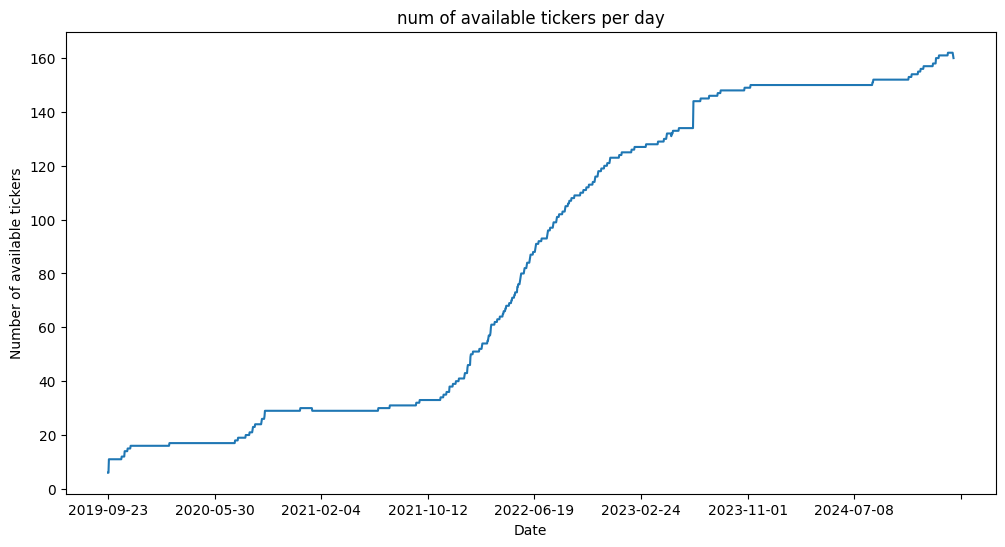

In [49]:
counts = pivot.notna().sum(axis=1)
counts.plot(kind='line', figsize=(12, 6), title='num of available tickers per day')
plt.xlabel('Date')
plt.ylabel('Number of available tickers')
plt.show()

In [51]:
counts
print('Compelled to model from 2019-11-15')

Compelled to model from 2019-11-15
